## Loading model

Please replace the `CKPT_PATH` to where the checkpoints saved.

In [1]:
CFG_PATH = '../configs/kl16_content12.yaml'
CKPT_PATH = '../checkpoints/kl16_content12/models/step=175000.ckpt'

DDIM_STEPS = 250
SEED = 2023
DEVICE = 'cuda'

In [2]:
import sys
sys.path.append('../')

import os
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_lightning import seed_everything
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
from einops import rearrange
from omegaconf import OmegaConf
import albumentations

from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

seed_everything(SEED)

config = OmegaConf.load(CFG_PATH)
config.model.params.ckpt_path = CKPT_PATH
config.model.params.first_stage_config.params.ckpt_path = None
model = instantiate_from_config(config.model)
model = model.eval().to(DEVICE)
model.move_scaler_shift()

Global seed set to 2023


DualCondLDM: Running in eps-prediction mode
DualConditionDiffusionWrapper has 181.08 M params.
Keeping EMAs of 205.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Training DualCondLDM as an adaptive conditional model.
Keeping EMAs of 3.
Restored from ../checkpoints/kl16_content12/models/step=175000.ckpt with 0 missing and 0 unexpected keys


In [3]:
def preprocess_image(image_path, size=(256, 256)):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = image.resize(size)
    image = np.array(image).astype(np.uint8)
    image = (image/127.5 - 1.0).astype(np.float32)
    image = rearrange(image, 'h w c -> c h w')
    return torch.from_numpy(image)


def display_samples(samples, n_columns=1, figsize=(12, 12)):
    if isinstance(samples, (list, tuple)):
        samples = torch.cat(samples, dim=0)
        
    samples = rearrange(samples, '(n m) c h w -> (m h) (n w) c', n=n_columns).cpu().numpy() * 255.
    samples = Image.fromarray(samples.astype(np.uint8))
    plt.rcParams["figure.figsize"] = figsize
    plt.imshow(samples)
    plt.axis('off')
    plt.show()

def tensor_to_rgb(x):
    return torch.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)

## Style Visulization

In [4]:
style_image_path = '../data/styles/d523d66a2f745aff1d3db21be993093fc.jpg'
style_image = preprocess_image(style_image_path)[None, :].to(DEVICE)

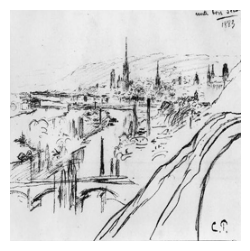

In [5]:
display_samples(tensor_to_rgb(style_image), figsize=(3, 3))

Use the partial style-conditional model to visualize the style learned by ArtFusion.

In [6]:
n_visual = 4

with torch.no_grad(), model.ema_scope("Plotting"):
    encoder_posterior = model.encode_first_stage(style_image)[0]
    encoder_posterior = model.get_first_stage_encoding(encoder_posterior)
    c_content = torch.zeros_like(encoder_posterior).expand(n_visual, -1, -1, -1)

    vgg_features = model.vgg(model.vgg_scaling_layer(style_image))
    c_style = model.get_style_features(vgg_features).expand(n_visual, -1)

    c = {'c1': c_content, 'c2': c_style}

    samples = model.sample_log(cond=c, batch_size=n_visual, ddim=True, ddim_steps=DDIM_STEPS, eta=1.)[0]

    x_samples = model.decode_first_stage(samples)
    x_samples = tensor_to_rgb(x_samples)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (4, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.03it/s]


Plotting: Restored training weights


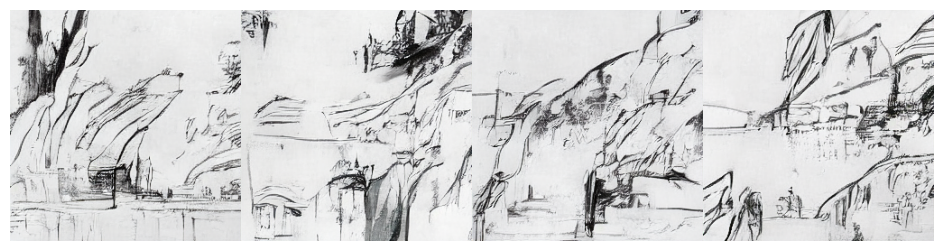

In [7]:
display_samples(x_samples, figsize=(3 * n_visual, 3), n_columns=n_visual)

## Two Dimensional Classifier-Free Guidance (2D-CFG)

The `content_scalers` and `style_scalers` are used to adjust the balance of content and style. With a higher content scaler, outputs will show clearer content. On the other hand, a higher style scaler results in a stronger stylization.

In [8]:
content_image_path = '../data/contents/lofoton.jpg'
style_image_path = '../data/styles/d523d66a2f745aff1d3db21be993093fc.jpg'

style_image = preprocess_image(style_image_path)[None, :].to(DEVICE)
content_image = preprocess_image(content_image_path)[None, :].to(DEVICE)

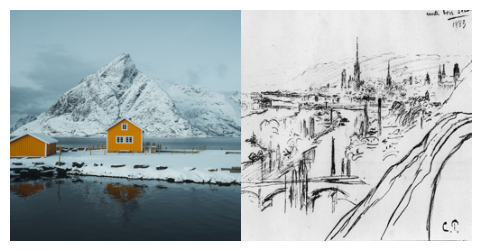

In [9]:
display_samples((tensor_to_rgb(content_image), tensor_to_rgb(style_image)), figsize=(6, 3), n_columns=2)

In [10]:
content_scalers = [0.25, 0.5, 1.0, 2.0, 4.0]
style_scalers = [0.15, 0.5, 1., 3., 5.]

with torch.no_grad(), model.ema_scope("Plotting"):
    vgg_features = model.vgg(model.vgg_scaling_layer(style_image))
    c_style = model.get_style_features(vgg_features)
    null_style = c_style.clone()
    null_style[:] = model.null_style_vector.weight[0]

    content_encoder_posterior = model.encode_first_stage(content_image)[0]
    content_encoder_posterior = model.get_first_stage_encoding(content_encoder_posterior)
    c_content = model.get_content_features(content_encoder_posterior)
    null_content = torch.zeros_like(c_content)

    c = {'c1': c_content, 'c2': c_style}
    c_null_style = {'c1': c_content, 'c2': null_style}
    c_null_content = {'c1': null_content, 'c2': c_style}
    
    samples = list()
    x_T = torch.randn_like(content_encoder_posterior)
    for style_s in style_scalers:
        for content_s in content_scalers:
            sample = model.sample_log(
                cond=c, batch_size=1, x_T=x_T,
                ddim=True, ddim_steps=DDIM_STEPS, eta=1.,
                unconditional_guidance_scale=content_s, unconditional_conditioning=c_null_content,
                unconditional_guidance_scale_2=style_s, unconditional_conditioning_2=c_null_style)[0]
            samples.append(sample)
    samples = torch.cat(samples, dim=0)
    x_samples = model.decode_first_stage(samples)
    x_samples = tensor_to_rgb(x_samples)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 69.64it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 69.61it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.89it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.64it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 69.50it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 67.33it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.20it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 69.73it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.90it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.75it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.99it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 72.32it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 73.89it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.73it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.67it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.62it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.38it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.93it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.41it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.17it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.93it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.85it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 68.34it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 70.17it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:03<00:00, 71.49it/s]

Plotting: Restored training weights


The content scaler increase from top to down, and style scalers increment from left to right.

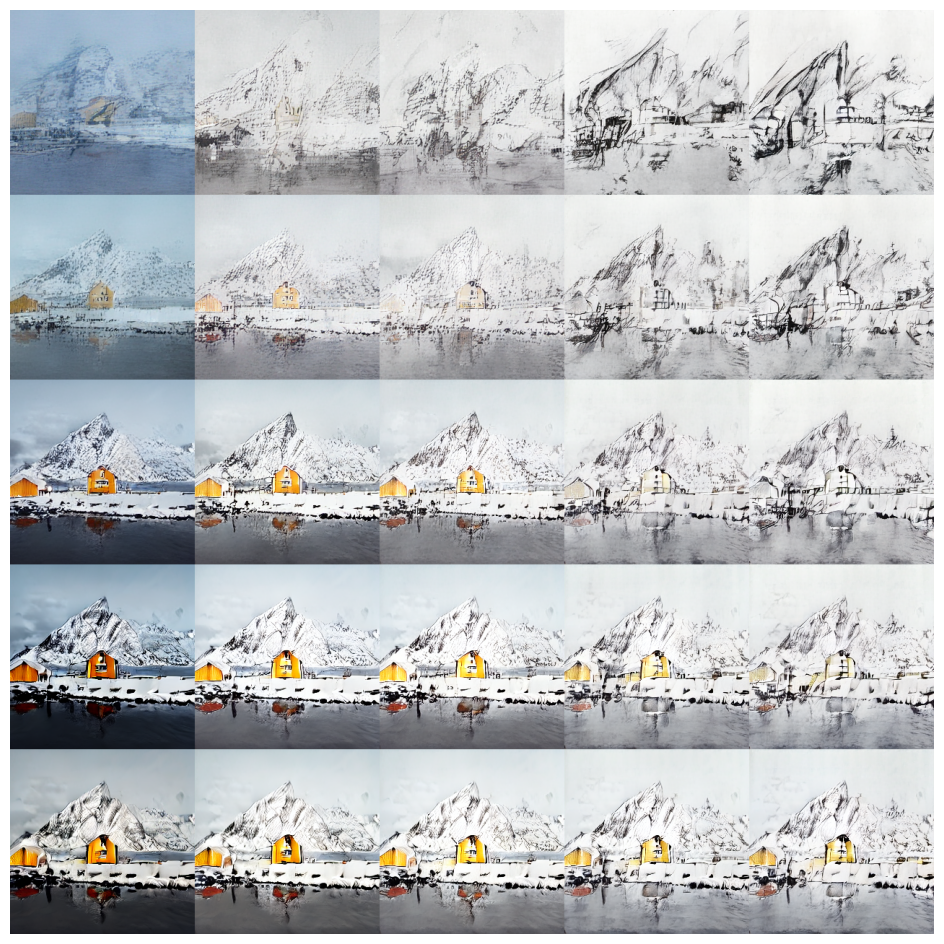

In [11]:
display_samples(x_samples, n_columns=len(style_scalers))

## Quick Sampling

For quick sampling, we can use only 10 `ddim_steps` along with `eta = 0.0` without serious loss of visual quality.

In [12]:
content_image_path = '../data/contents/lofoton.jpg'
style_image_path = '../data/styles/d523d66a2f745aff1d3db21be993093fc.jpg'

style_image = preprocess_image(style_image_path)[None, :].to(DEVICE)
content_image = preprocess_image(content_image_path)[None, :].to(DEVICE)

content_scalers = [0.25, 0.5, 1.0, 2.0, 4.0]
style_scalers = [0.15, 0.5, 1., 3., 5.]

with torch.no_grad(), model.ema_scope("Plotting"):
    vgg_features = model.vgg(model.vgg_scaling_layer(style_image))
    c_style = model.get_style_features(vgg_features)
    null_style = c_style.clone()
    null_style[:] = model.null_style_vector.weight[0]

    content_encoder_posterior = model.encode_first_stage(content_image)[0]
    content_encoder_posterior = model.get_first_stage_encoding(content_encoder_posterior)
    c_content = model.get_content_features(content_encoder_posterior)
    null_content = torch.zeros_like(c_content)

    c = {'c1': c_content, 'c2': c_style}
    c_null_style = {'c1': c_content, 'c2': null_style}
    c_null_content = {'c1': null_content, 'c2': c_style}
    
    samples = list()
    x_T = torch.randn_like(content_encoder_posterior)
    for style_s in style_scalers:
        for content_s in content_scalers:
            sample = model.sample_log(
                cond=c, batch_size=1, x_T=x_T,
                ddim=True, ddim_steps=10, eta=0.,
                unconditional_guidance_scale=content_s, unconditional_conditioning=c_null_content,
                unconditional_guidance_scale_2=style_s, unconditional_conditioning_2=c_null_style)[0]
            samples.append(sample)
    samples = torch.cat(samples, dim=0)
    x_samples = model.decode_first_stage(samples)
    x_samples = tensor_to_rgb(x_samples)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.51it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.95it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.61it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.42it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.02it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.57it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.55it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.84it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.24it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.42it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.80it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.43it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.95it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.53it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.41it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.15it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.85it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.28it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.66it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.65it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.17it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.77it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.69it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.92it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 0.0
Running DDIM Sampling with 10 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.30it/s]

Plotting: Restored training weights


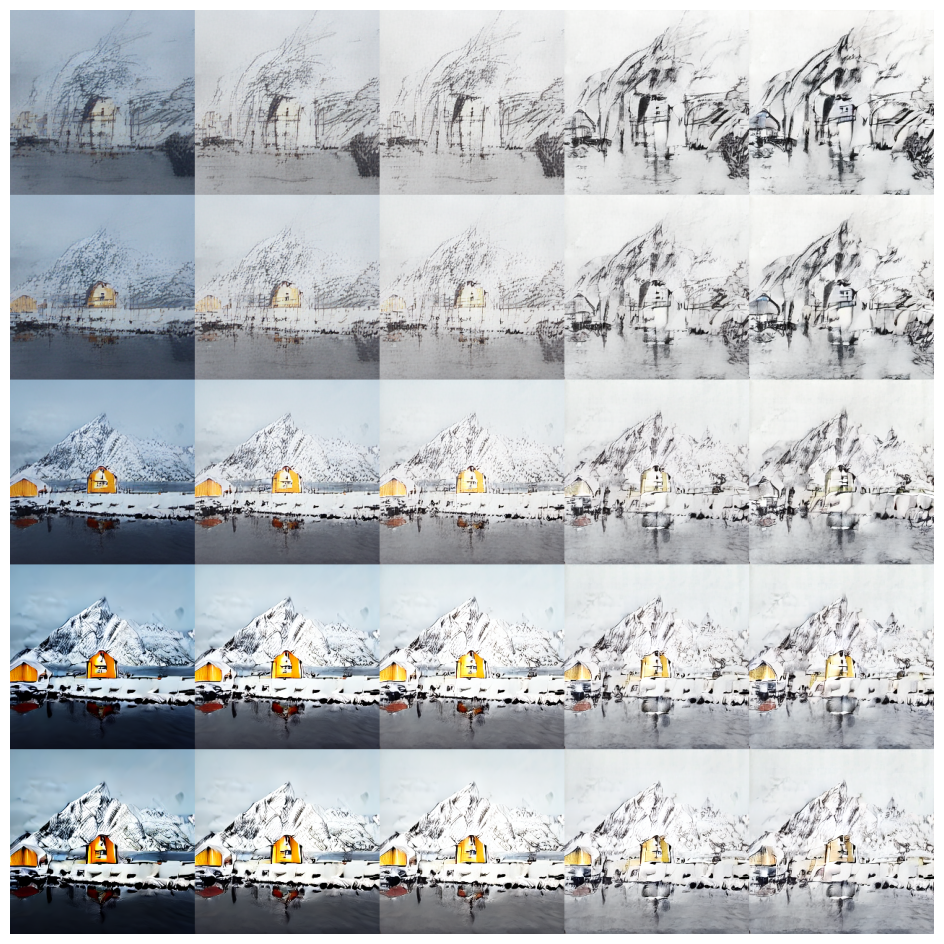

In [13]:
display_samples(x_samples, n_columns=len(style_scalers))

## High Resolution Sampling

We can adopt lower `content_s` and higher `style_s` when working on high-resolution images.

In [14]:
content_image_path = '../data/contents/taiwan.jpg'
style_image_path = '../data/styles/df66247b2563f34f74259b4946d3c22ac.jpg'

style_image = preprocess_image(style_image_path)[None, :].to(DEVICE)
content_image = preprocess_image(content_image_path, size=(1920, 480))[None, :].to(DEVICE)

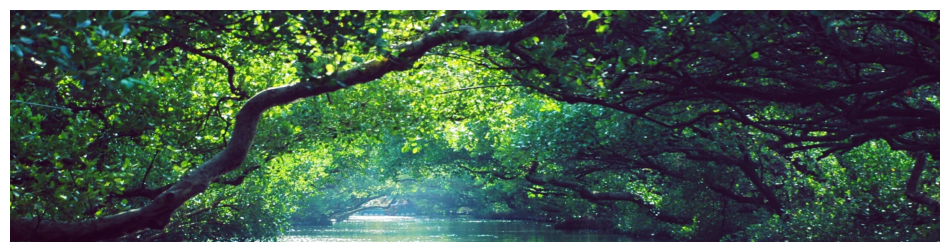

In [15]:
display_samples(tensor_to_rgb(content_image))

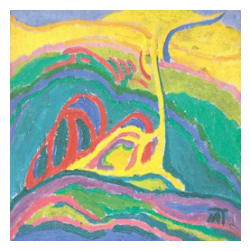

In [16]:
display_samples(tensor_to_rgb(style_image), figsize=(3, 3))

In [17]:
content_s = 0.25
style_s = 4.0


with torch.no_grad(), model.ema_scope("Plotting"):
    vgg_features = model.vgg(model.vgg_scaling_layer(style_image))
    c_style = model.get_style_features(vgg_features)
    null_style = c_style.clone()
    null_style[:] = model.null_style_vector.weight[0]

    content_encoder_posterior = model.encode_first_stage(content_image)[0]
    content_encoder_posterior = model.get_first_stage_encoding(content_encoder_posterior)
    c_content = model.get_content_features(content_encoder_posterior)
    null_content = torch.zeros_like(c_content)

    c = {'c1': c_content, 'c2': c_style}
    c_null_style = {'c1': c_content, 'c2': null_style}
    c_null_content = {'c1': null_content, 'c2': c_style}
    
    x_T = torch.randn_like(content_encoder_posterior)
    samples = model.sample_log(
        cond=c, batch_size=1, x_T=x_T,
        ddim=True, ddim_steps=250, eta=1.,
        unconditional_guidance_scale=content_s, unconditional_conditioning=c_null_content,
        unconditional_guidance_scale_2=style_s, unconditional_conditioning_2=c_null_style)[0]
    x_samples = model.decode_first_stage(samples)
    x_samples = tensor_to_rgb(x_samples)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 250/250 [00:25<00:00,  9.71it/s]

Plotting: Restored training weights


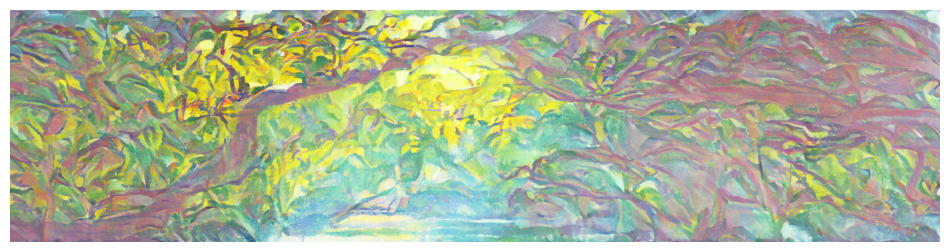

In [18]:
display_samples(x_samples)